开始运行: 实验2: 诱发性劫持（对抗攻击）
训练基础分类模型...
训练批次出错，跳过: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.
训练批次出错，跳过: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.
Epoch 1: Loss=0.7657, Accuracy=12.50%
训练批次出错，跳过: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed

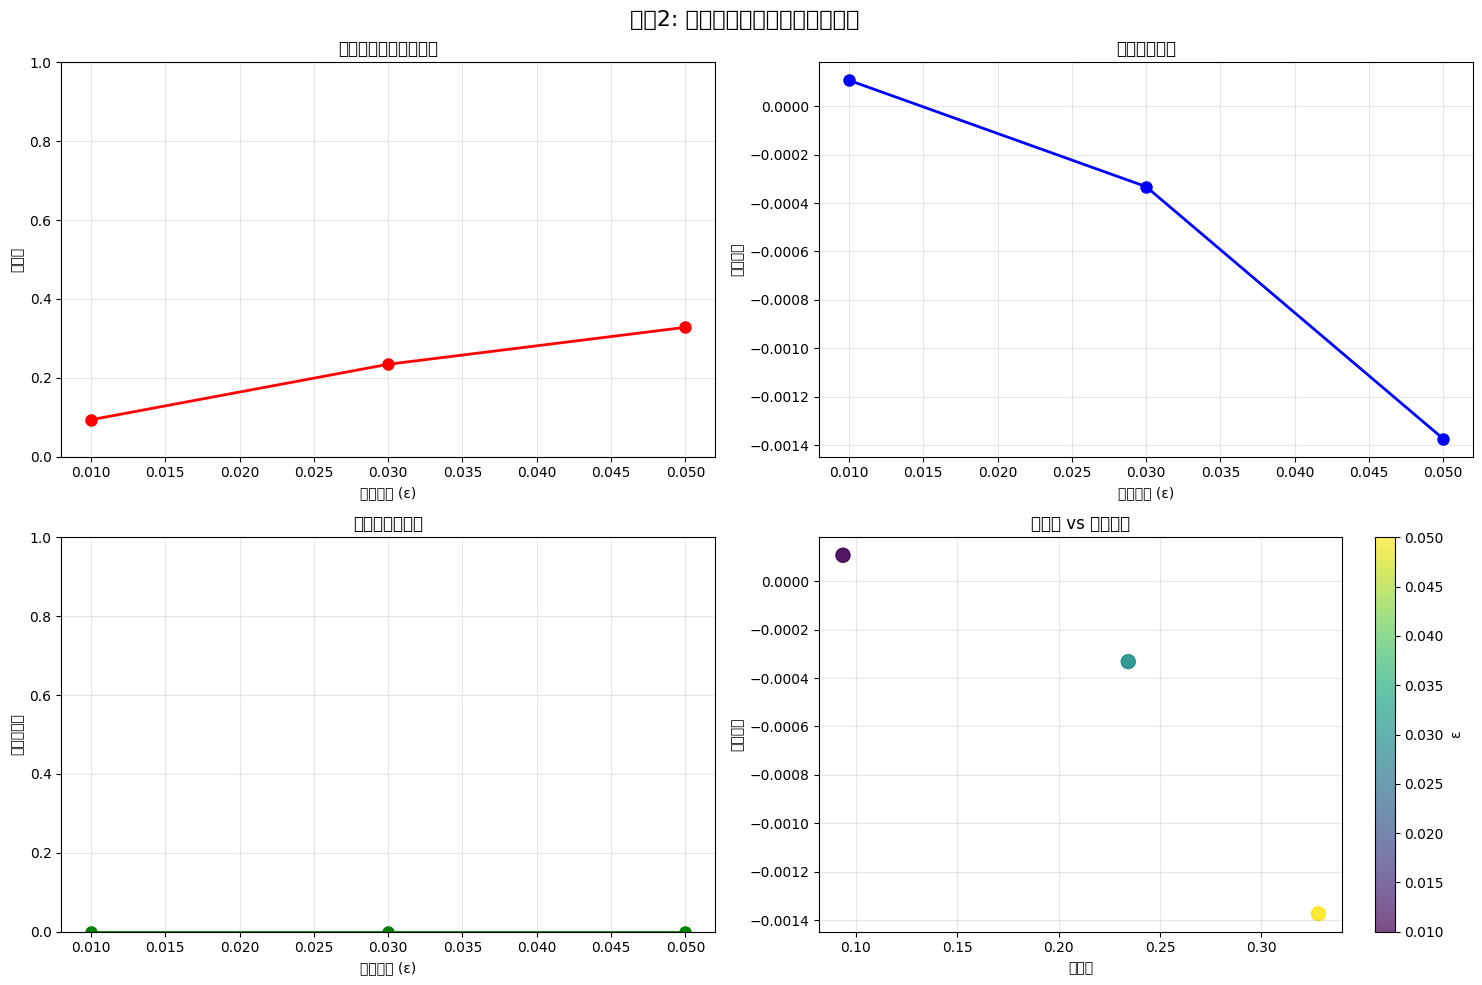


实验2总结:
- 最大劫持率: 32.81% (ε=0.05)
- 平均劫持率: 21.88%
- 平均信心下降: -0.001
- 平均路径切换率: 0.00%
✅ 实验2: 诱发性劫持（对抗攻击） 完成



In [ ]:
# Cell 5: 实验2 - 诱发性劫持（对抗攻击）
# ================================================================================

def run_adversarial_hijacking_experiment(n_samples=500, epsilon_range=[0.01, 0.05, 0.1],
                                        show_plot=True):
    """
    实验2: 诱发性劫持 - 对抗攻击导致的决策劫持
    """

    print("================================================================================")
    print("开始运行: 实验2: 诱发性劫持（对抗攻击）")
    print("================================================================================")

    # 创建数据
    X, y = create_mnist_like_data(n_samples, img_size=28)

    # 创建数据加载器
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

    # 创建并训练基础模型
    print("训练基础分类模型...")
    model = FixedDualPathModel(input_dim=784, hidden_dim=64, num_classes=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # 快速训练几个epoch
    model.train()
    for epoch in range(3):
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(dataloader):
            try:
                # 展平图像数据
                data = data.view(data.size(0), -1)

                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

            except Exception as e:
                print(f"训练批次出错，跳过: {e}")
                continue

        accuracy = 100. * correct / total if total > 0 else 0
        print(f"Epoch {epoch+1}: Loss={total_loss/len(dataloader):.4f}, Accuracy={accuracy:.2f}%")

    print("基础模型训练完成，开始对抗攻击实验...")

    # 对抗攻击实验
    model.eval()
    results = {
        'epsilon_values': [],
        'hijacking_rates': [],
        'confidence_drops': [],
        'path_switching': []
    }

    # 获取测试数据
    test_data, test_labels = next(iter(dataloader))
    test_data = test_data.view(test_data.size(0), -1)

    for epsilon in epsilon_range:
        print(f"\n测试 ε = {epsilon}")

        # 创建对抗攻击器
        attacker = AdversarialAttacker(model, epsilon=epsilon)

        with torch.no_grad():
            # 原始预测
            original_output = model(test_data, return_paths=True)
            if isinstance(original_output, tuple):
                orig_pred, orig_paths = original_output
            else:
                orig_pred = original_output
                orig_paths = None

            orig_labels = orig_pred.argmax(dim=1)
            orig_confidence = F.softmax(orig_pred, dim=1).max(dim=1)[0]

        # 生成对抗样本
        adv_data = attacker.fgsm_attack(test_data, test_labels)

        with torch.no_grad():
            # 对抗样本预测
            adv_output = model(adv_data, return_paths=True)
            if isinstance(adv_output, tuple):
                adv_pred, adv_paths = adv_output
            else:
                adv_pred = adv_output
                adv_paths = None

            adv_labels = adv_pred.argmax(dim=1)
            adv_confidence = F.softmax(adv_pred, dim=1).max(dim=1)[0]

        # 计算劫持率
        hijacked = (orig_labels != adv_labels).float()
        hijacking_rate = hijacked.mean().item()

        # 计算信心下降
        confidence_drop = (orig_confidence - adv_confidence).mean().item()

        # 计算路径切换（如果有路径信息）
        path_switch = 0.0
        if orig_paths and adv_paths and 'gate_weight' in orig_paths:
            gate_diff = torch.abs(orig_paths['gate_weight'] - adv_paths['gate_weight'])
            path_switch = (gate_diff > 0.3).float().mean().item()

        results['epsilon_values'].append(epsilon)
        results['hijacking_rates'].append(hijacking_rate)
        results['confidence_drops'].append(confidence_drop)
        results['path_switching'].append(path_switch)

        print(f"  劫持率: {hijacking_rate:.2%}")
        print(f"  信心下降: {confidence_drop:.3f}")
        print(f"  路径切换率: {path_switch:.2%}")

    # 可视化结果
    if show_plot:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('实验2: 诱发性劫持（对抗攻击）结果', fontsize=16)

        # 劫持率 vs epsilon
        axes[0, 0].plot(epsilon_range, results['hijacking_rates'], 'ro-', linewidth=2, markersize=8)
        axes[0, 0].set_xlabel('扰动强度 (ε)')
        axes[0, 0].set_ylabel('劫持率')
        axes[0, 0].set_title('劫持率随扰动强度变化')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_ylim(0, 1)

        # 信心下降
        axes[0, 1].plot(epsilon_range, results['confidence_drops'], 'bo-', linewidth=2, markersize=8)
        axes[0, 1].set_xlabel('扰动强度 (ε)')
        axes[0, 1].set_ylabel('信心下降')
        axes[0, 1].set_title('预测信心下降')
        axes[0, 1].grid(True, alpha=0.3)

        # 路径切换率
        axes[1, 0].plot(epsilon_range, results['path_switching'], 'go-', linewidth=2, markersize=8)
        axes[1, 0].set_xlabel('扰动强度 (ε)')
        axes[1, 0].set_ylabel('路径切换率')
        axes[1, 0].set_title('双路径切换频率')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_ylim(0, 1)

        # 综合分析
        axes[1, 1].scatter(results['hijacking_rates'], results['confidence_drops'],
                          c=epsilon_range, s=100, alpha=0.7, cmap='viridis')
        axes[1, 1].set_xlabel('劫持率')
        axes[1, 1].set_ylabel('信心下降')
        axes[1, 1].set_title('劫持率 vs 信心下降')
        axes[1, 1].grid(True, alpha=0.3)

        # 添加colorbar
        scatter = axes[1, 1].scatter(results['hijacking_rates'], results['confidence_drops'],
                                   c=epsilon_range, s=100, alpha=0.7, cmap='viridis')
        plt.colorbar(scatter, ax=axes[1, 1], label='ε')

        plt.tight_layout()
        plt.show()

    # 统计总结
    max_hijacking = max(results['hijacking_rates'])
    avg_hijacking = np.mean(results['hijacking_rates'])

    print(f"\n实验2总结:")
    print(f"- 最大劫持率: {max_hijacking:.2%} (ε={epsilon_range[np.argmax(results['hijacking_rates'])]})")
    print(f"- 平均劫持率: {avg_hijacking:.2%}")
    print(f"- 平均信心下降: {np.mean(results['confidence_drops']):.3f}")
    print(f"- 平均路径切换率: {np.mean(results['path_switching']):.2%}")

    return results

# 运行实验2
if RUN_E2:
    try:
        exp2_results = run_adversarial_hijacking_experiment(
            n_samples=200,  # 减少样本数以加快实验
            epsilon_range=[0.01, 0.03, 0.05],
            show_plot=True
        )
        print("✅ 实验2: 诱发性劫持（对抗攻击） 完成")
        print()
    except Exception as e:
        print(f"❌ 实验2失败: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⏭️ 实验2已跳过")